In [1]:
#環境確認
import pandas as pd
import numpy as np
import sklearn
!python3 --version
print(pd.__version__)
print(np.__version__)
print(sklearn.__version__)
import matplotlib
print(matplotlib.__version__)

Python 3.6.12 :: Anaconda, Inc.
1.1.1
1.19.1
0.23.2
3.3.1


In [2]:
#データの読み込みと前処理
train_data = pd.read_csv("Data/train_data.csv", index_col='id')
print(train_data.shape)

(66125, 31)


In [3]:
train_data.head()

,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,A2-weapon,...,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level,y
id,,,,,,,,,,,,,,,,,,,,,
1,2019-10-15T20:00:00+00:00,5.0.1,regular,standard,nawabari,sumeshi,sshooter_becchu,NaN,139,soytuber_custom,...,hokusai_becchu,NaN,26.0,herocharger_replica,NaN,68.0,sharp_neo,NaN,31.0,1
2,2019-12-14T04:00:00+00:00,5.0.1,regular,standard,nawabari,arowana,parashelter_sorella,NaN,198,jetsweeper,...,squiclean_b,NaN,118.0,campingshelter,NaN,168.0,sputtery_clear,NaN,151.0,0
3,2019-12-25T14:00:00+00:00,5.0.1,gachi,standard,hoko,ama,nzap89,a-,114,quadhopper_black,...,nzap85,a+,163.0,prime_becchu,a-,160.0,dualsweeper_custom,a,126.0,0
4,2019-11-11T14:00:00+00:00,5.0.1,regular,standard,nawabari,engawa,bamboo14mk1,NaN,336,splatroller_becchu,...,liter4k,NaN,189.0,promodeler_mg,NaN,194.0,hotblaster_custom,NaN,391.0,0
5,2019-12-14T06:00:00+00:00,5.0.1,gachi,standard,hoko,chozame,bold_7,x,299,hissen_hue,...,sputtery_hue,x,45.0,bucketslosher_soda,x,246.0,wakaba,x,160.0,1


In [4]:
np.sum(train_data['y'] == 1) / train_data['y'].count(), np.sum(train_data['y'] == 0) / train_data['y'].count()

(0.524703213610586, 0.47529678638941397)

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66125 entries, 1 to 66125
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   period      66125 non-null  object 
 1   game-ver    66125 non-null  object 
 2   lobby-mode  66125 non-null  object 
 3   lobby       66125 non-null  object 
 4   mode        66125 non-null  object 
 5   stage       66125 non-null  object 
 6   A1-weapon   66125 non-null  object 
 7   A1-rank     51681 non-null  object 
 8   A1-level    66125 non-null  int64  
 9   A2-weapon   66125 non-null  object 
 10  A2-rank     51681 non-null  object 
 11  A2-level    66125 non-null  float64
 12  A3-weapon   66125 non-null  object 
 13  A3-rank     51681 non-null  object 
 14  A3-level    66125 non-null  float64
 15  A4-weapon   66074 non-null  object 
 16  A4-rank     51638 non-null  object 
 17  A4-level    66074 non-null  float64
 18  B1-weapon   66125 non-null  object 
 19  B1-rank     51681 non-nul

In [6]:
from sklearn.preprocessing import MultiLabelBinarizer

In [7]:
mlb = MultiLabelBinarizer()
mlb.fit([set(train_data['A1-weapon'].unique())])

MultiLabelBinarizer()

In [8]:
def trans_weapon(df, columns=['A1-weapon', 'A2-weapon', 'A3-weapon', 'A4-weapon']):
    weapon = df.fillna('none') 
    weapon_binarized = mlb.transform(weapon[columns].values)
    return pd.DataFrame(weapon_binarized, columns=mlb.classes_)

def make_input_output(df, with_y=False):
    a_weapon = trans_weapon(df, ['A1-weapon', 'A2-weapon', 'A3-weapon', 'A4-weapon'])
    b_weapon = trans_weapon(df, ['B1-weapon', 'B2-weapon', 'B3-weapon', 'B4-weapon'])
    X = pd.concat([a_weapon, b_weapon], axis=1)
    if with_y:
        y = df['y']
        return X, y
    return X

In [9]:
X, y = make_input_output(train_data, with_y=True)

/opt/anaconda3/envs/spla/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:995: UserWarning: unknown class(es) ['none'] will be ignored
  .format(sorted(unknown, key=str)))


In [10]:
#scikit-learnライブラリをimport
import sklearn
from sklearn.ensemble import RandomForestClassifier

#線形回帰モデルのインスタンス化
model = RandomForestClassifier()

#予測モデルの作成
model.fit(X, y)

RandomForestClassifier()

In [11]:
list(reversed(sorted(list(zip(model.feature_importances_, X.columns)))))[:10]

[(0.01369338767835914, 'prime_becchu'),
 (0.011496003033728887, 'splatroller'),
 (0.010738931692563892, 'nzap85'),
 (0.010508018059754043, 'splatroller'),
 (0.01043445397989815, 'nzap89'),
 (0.010220803963441064, 'prime_becchu'),
 (0.010122493186663585, 'wakaba'),
 (0.009592493288061391, 'wakaba'),
 (0.009534039289199771, 'nzap89'),
 (0.009193470446953041, 'dualsweeper_custom')]

In [12]:
# accuracyの出力
from sklearn.metrics import accuracy_score
y_true = y
y_pred = model.predict(X)
print(accuracy_score(y_true, y_pred))

0.9999848771266541


In [13]:
path_test = "Data/test_data.csv"
test_data = pd.read_csv(path_test, index_col='id')
test_data.head()

,period,game-ver,lobby-mode,lobby,mode,stage,A1-weapon,A1-rank,A1-level,A2-weapon,...,B1-level,B2-weapon,B2-rank,B2-level,B3-weapon,B3-rank,B3-level,B4-weapon,B4-rank,B4-level
id,,,,,,,,,,,,,,,,,,,,,
1,2019-12-17T12:00:00+00:00,5.0.1,gachi,standard,area,hakofugu,prime_collabo,x,174,herospinner_replica,...,160,nautilus47,x,151.0,l3reelgun_d,x,213.0,nzap89,x,306.0
2,2019-11-25T16:00:00+00:00,5.0.1,gachi,standard,asari,anchovy,prime_becchu,s+,363,nzap89,...,326,dualsweeper_custom,s+,289.0,prime_becchu,s+,147.0,splatroller,s+,156.0
3,2019-10-22T08:00:00+00:00,5.0.1,gachi,standard,area,mutsugoro,furo_deco,s,116,bold,...,76,momiji,s,232.0,nzap83,s,183.0,promodeler_pg,s,105.0
4,2019-12-30T04:00:00+00:00,5.0.1,gachi,standard,asari,devon,prime_becchu,s+,192,splatspinner_collabo,...,90,quadhopper_black,s+,119.0,soytuber,s+,172.0,prime,s+,70.0
5,2019-10-15T16:00:00+00:00,5.0.1,gachi,standard,yagura,anchovy,l3reelgun_d,x,267,rapid_becchu,...,259,sshooter_becchu,x,198.0,splatscope,x,50.0,screwslosher_becchu,x,287.0


In [14]:
test_X = make_input_output(test_data)

/opt/anaconda3/envs/spla/lib/python3.6/site-packages/sklearn/preprocessing/_label.py:995: UserWarning: unknown class(es) ['none'] will be ignored
  .format(sorted(unknown, key=str)))


In [15]:
#テスト結果の出力
test_predicted = model.predict(test_X)
submit_df = pd.DataFrame({'y': test_predicted})
submit_df.index.name = 'id'
submit_df.to_csv('Submissions/submission.csv')

## ここから自分で実装

In [16]:
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import lightgbm as lgb
from lightgbm import LGBMClassifier


random.seed(0)

/opt/anaconda3/envs/spla/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [17]:
# 全データを5つに分割
SIZE = X.shape[0]
K = 5

def make_kfolds(SIZE, K):
    # return list object, each element is indices of its fold
    FOLD_SIZE = int(SIZE/K)
    res = []
    indices = [i for i in range(SIZE)]
    for i in range(K-1):
        fold = random.sample(indices, FOLD_SIZE)
        indices = list(set(indices) - set(fold))
        res.append(fold)
    res.append(indices)
    return res

folds = make_kfolds(SIZE, K)
print(len(folds))
for i, fold in enumerate(folds):
    print("fold ", i+1, " size is ", len(fold))
    

    
if SIZE != len(set(sum(folds, []))):
    print("error is occuring in spliting")
else :
    print("successfully split")


5
fold  1  size is  13225
fold  2  size is  13225
fold  3  size is  13225
fold  4  size is  13225
fold  5  size is  13225
successfully split


In [53]:
param = {
    "num_leaves" : 20,
    "n_estimators" : 100,
    "learning_rate" : 0.1,
    "num_iterations" : 50,
    "objective" : "binary",
    "metric" : ["binary_logloss"],
}

THRESHOLD = 0.51
models = []
cv_scores = []

all_indices = sum(folds, [])
for i in range(K):
    valid_indices = folds[i]
    train_indices = list(set(all_indices) - set(valid_indices))
    # print("train ", len(train_indices), " , valid ", len(valid_indices))
    train_X = X.iloc[train_indices].values
    train_y = y.iloc[train_indices].values
    valid_X = X.iloc[valid_indices].values
    valid_y = y.iloc[valid_indices].values
    
    train_data = lgb.Dataset(train_X, label=train_y)
    valid_data = lgb.Dataset(valid_X, label=valid_y)
    
    model = lgb.train(param, train_data, valid_sets=valid_data, early_stopping_rounds=2, verbose_eval=10)
    pred = model.predict(valid_X)
    pred = np.where(pred < THRESHOLD, 0, 1)
    
    #model = LGBMClassifier()
    #model.set_params(**param)
    
    #model.fit(train_X, train_y, eval_set=(valid_X, valid_y),  early_stopping_rounds=1, verbose=False)
    #pred = model.predict(valid_X)
    score = accuracy_score(pred, valid_y)
    
    models.append(model)
    cv_scores.append(score)
    
    
print("cv score : ", np.mean(cv_scores))    

Training until validation scores don't improve for 2 rounds
[10]	valid_0's binary_logloss: 0.690586
[20]	valid_0's binary_logloss: 0.689553
[30]	valid_0's binary_logloss: 0.688889
[40]	valid_0's binary_logloss: 0.688666
Early stopping, best iteration is:
[42]	valid_0's binary_logloss: 0.688625
Training until validation scores don't improve for 2 rounds
[10]	valid_0's binary_logloss: 0.689467
[20]	valid_0's binary_logloss: 0.688654
[30]	valid_0's binary_logloss: 0.688145
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.687953
Training until validation scores don't improve for 2 rounds
[10]	valid_0's binary_logloss: 0.689599
[20]	valid_0's binary_logloss: 0.688677
Early stopping, best iteration is:
[26]	valid_0's binary_logloss: 0.688265
Training until validation scores don't improve for 2 rounds
[10]	valid_0's binary_logloss: 0.688293
[20]	valid_0's binary_logloss: 0.687313
Early stopping, best iteration is:
[18]	valid_0's binary_logloss: 0.687295
Training until valid

0.5270093969054028
0.5247101552746444
0.523681623239878
0.5219899760487852
0.5237909131933219
0.5242364129324065


array([[<AxesSubplot:title={'center':'pred'}>]], dtype=object)

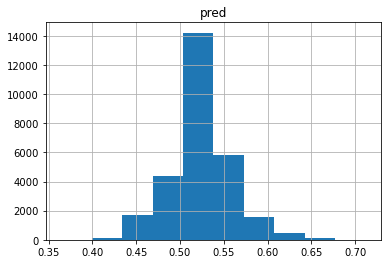

In [54]:
preds = []
for i in range(K):
    model = models[i]
    pred = model.predict(test_X)
    preds.append(pred)
    print(np.sum(pred) / pred.shape[0])
    
preds = np.array(preds)
preds = np.mean(preds, axis=0)
print(np.sum(preds) / preds.shape[0])


temp = pd.DataFrame({"pred":pred})
temp.hist()

In [55]:
preds = np.where(preds < THRESHOLD, 0, 1)
print(np.sum(preds) / preds.shape[0])

submit_df = pd.DataFrame({'y': preds})
submit_df.index.name = 'id'
submit_df.to_csv('Submissions/submission3.csv')

0.7375793930839802
